# Detecting Activity Types from Accelerometer Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.signal import welch

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from load import load_signal_data
from plots import *
from signal_processing import *

In [4]:
train_signals, train_labels, test_signals, test_labels = load_signal_data()

### Background and Data Source

The data is captured by accelerometers in Samsung Galaxy phones, which were attached to subjects' waists while they participated in 6 different activities:

* 1: walking
* 2: walking up stairs
* 3: walking down stairs
* 4: sitting
* 5: standing
* 6: laying

The following 6 plots show how the accelerometer data differ between each activity

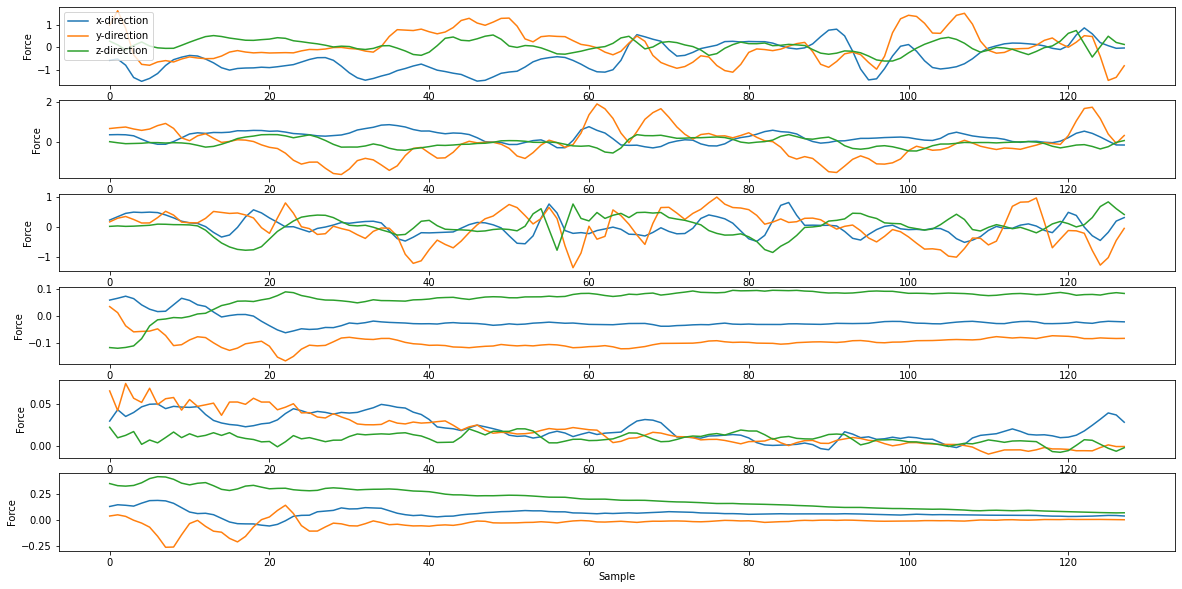

In [5]:
show_true_signals(train_signals, train_labels)

The data consists of 10,299 samples, each of which is composed of 9 different signals. The signals are separated into "acceleration", "gyroscopic motion", and "total acceleration", each in the x, y, and z directions (3 types of motion in 3 directions = 9 signals per sample). We can imagine a single sample of 9 signals as represented in the 3D plot below. 

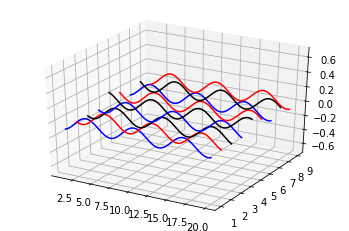

In [2]:
show_single_sample()

Each of these 9 signals is made up of 128 data points. Therefore, the data is stored in a matrix of size 10,299 x 128 x 9. We have to extract specific characteristics from each of the 9 signals using signal processing techniques. This will allow us to represent each sample as a single horizontal vector and build our feature matrix. This will be a 2-D matrix of size 10,299 x m (where m is the number of features). Finally, we can use this matrix to train a Random Forest classifier.  

The original dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) is already separated into a train and test set, so we'll first concatenate these sample matrices and target vectors such that we can run k-fold cross validation later on.


In [23]:
signals = np.concatenate([train_signals, test_signals])
labels = np.concatenate([train_labels, test_labels])
signals.shape, train_signals.shape

((10299, 128, 9), (7352, 128, 9))

Now, we'll walk throuh an explanation of how we extract the features from the 9 signals that compose each sample. This is done with the *Fourier Transform* and the *Autocorrelation*. 

### Signal Processing Techniques: The Fourier Transform and Autocorrelation

The Fourier transform helps us represent signals in the frequency/amplitude domain rather than the time/amplitude domain. It allows us to extract the underlying frequencies in a signal that may be composed of more than just one. 

Below, we use a set of sample sine waves, each of which is given by the equation:

>$$ y = Asin(2\pi\omega t)$$
>
> where $A$ represents the amplitude
>
>and $\omega$ represents the angular frequency in radians per second

The Fourier Transform is given by the equation:


$$F(\omega)= \int_{-\infty}^{\infty}{f(t)e^{-j\omega t}dt}$$

We set the signal length to 10 seconds and the number of samples to 1000, which means that we are collecting 100 samples per second (i.e. our sample frequency is 100 Hz).

Each individual sine wave is modeled by the curves in blue through red with the following frequencies and amplitudes:

| Color       | Frequency $\omega$   | Amplitude $A$ |
| ----------- | ----------- |---------- |
| Blue        | 6.5         |      4     |
| Orange      | 5           |      6     |
| Purple      | 3           |      8     |
| Green       | 1.5         |     10      |
| Red         | 1           |     14      |
 

Then they are summed up to create the composite wave in black in the plots below. The Fourier Transform can help us extract the underlying frequencies in this black sinusoid, which we know should be 6.5, 5, 3, 1.5, 1 radians per second respectively. The plot of frequencies vs. amplitudes should also show that the amplitude for the 1 rad/sec frequency is most prominent (i.e. largest amplitude) followed by the 1.5 rad/sec frequency, etc.


In [8]:
t_n = 10     #timespan
N = 1000     #number of points in each signal
T = t_n / N  #time interval between points
f_s = 1/T    #sampling frequency

x = np.linspace(0, t_n, N)

amplitudes  =  [4, 6, 8, 10, 14]
frequencies =  [6.5, 5, 3, 1.5, 1]


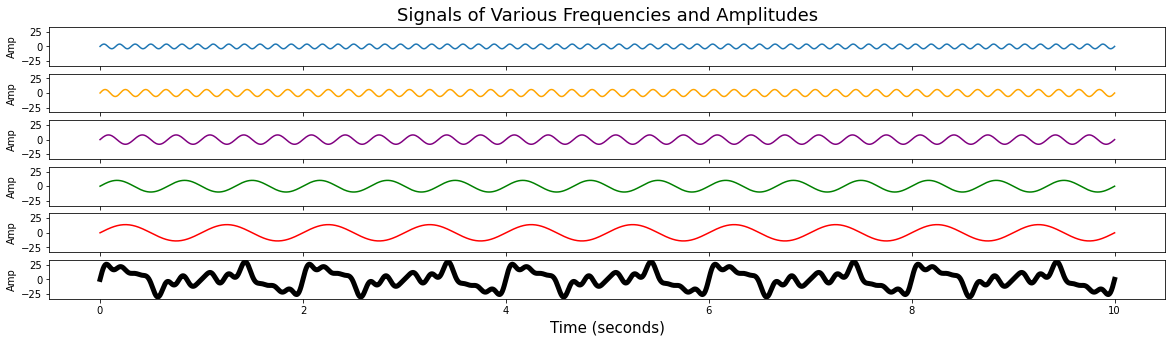

In [9]:
composite_y_value = plot_premade_signals(x, amplitudes,frequencies)

Here, we implement the `signal_processing.get_fourier_peaks` function that will first extract the underlying frequencies from our black composite sine wave. 

We'll check to see that it works properly, then use it to extract features for our machine learning model down the line.

Frequencies: [1.  1.5 3.  5.  6.5], 
Corresponding Amplitudes: [14.02  9.97  7.98  5.96  3.93]


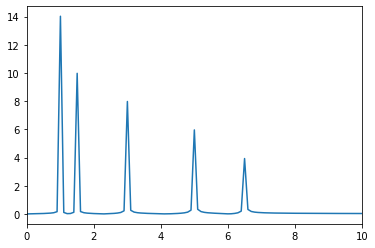

In [10]:
get_fourier_peaks(composite_y_value, samplingFrequency=100,npeaks =5, demo = True)
plt.xlim(0,10)
plt.show()

Sure enough, the locations of the peaks in the plot above reflect the frequencies and amplitudes we selected. We designed a composite curve so that we could build a fourier transform function and make sure it will work when we apply it to our real signals. 

We carry out the same demonstration of how autocorrelation works in the `autocorr.ipynb` notebook. The `signal_processing.get_autocorr_peaks` basically lets us understand how each signal relates to a time-shifted version of itself. 

Time Delays: [0.64 0.77 1.   1.22 1.35], 
Corresponding Amplitudes: [15219.86 33485.7  80979.03 51641.02 27986.61]


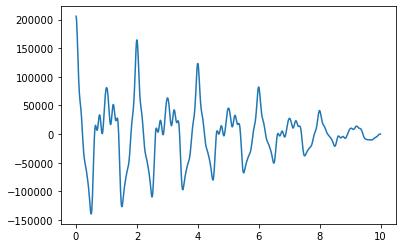

In [11]:
get_autocorr_peaks(composite_y_value, T = T, N = N, demo = True, npeaks = 5)

#### Extracting a 2D Array

Each signal processing function will extract `npeaks` features. For example, if we pass in `npeaks = 5` to the `get_fourier_peaks` function, it will output 10 datapoints:
* 5 data points reflecting the underlying frequencies of the signal
* 5 data points reflecting the amplitudes of these frequencies

Each row vector therefore becomes 10 data points per function per signal. 10 * 2 * 9 = 180 features. This is extracted by our `get_features` function. Our final 2D matrix stacks these vectors vertically and becomes 10,299 x 180 in size.

In [20]:
def get_features(signals, peaks = 5):
    '''Input: 9 x 128 array from one sample of our 3D matrix
       Output: Row vector of size 9*2*2*npeaks for use in our 2D array'''
    
    signals = signals.T
    f_peaks = []
    for i in range(signals.shape[0]):
        f_peaks.append(get_fourier_peaks(signals[i], npeaks = peaks))
        f_peaks.append(get_autocorr_peaks(signals[i], npeaks = peaks))
    
    return(np.array(f_peaks).reshape(-1))


----

### Building a Model

In [24]:
X = []
y = []

for i in range(signals.shape[0]):
    X.append(get_features(signals[i]))
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

In [25]:
X.shape, y.shape

((10299, 180), (10299,))

In [22]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, stratify = y, random_state = i)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    clf = RandomForestClassifier(n_estimators=300)
    clf.fit(X_train_std, y_train)
    print(f'Random State: {i}, Score: {clf.score(X_test_std, y_test)}')

Random State: 0, Score: 0.9237864077669903
Random State: 1, Score: 0.9169902912621359
Random State: 2, Score: 0.9174757281553398
Random State: 3, Score: 0.9111650485436893
Random State: 4, Score: 0.9092233009708738
Random State: 5, Score: 0.912621359223301
Random State: 6, Score: 0.9237864077669903
Random State: 7, Score: 0.9063106796116505
Random State: 8, Score: 0.912621359223301
Random State: 9, Score: 0.903883495145631
